In [136]:
import pandas as pd
import numpy as np
import copy
from time import process_time
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

# datasets
from keras.datasets import mnist
from sklearn.datasets import load_digits

from sklearn.cluster import KMeans 
from sklearn.neighbors import NearestNeighbors, NearestCentroid
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# **PART I: Code**

In [137]:
# Perform principal component analysis.
def pca(X):
    means = np.mean(X.T, axis=1)
    centered = X - means
    cov = np.cov(centered.T)
    weights, vectors = np.linalg.eigh(cov)
    return means, weights, vectors

# Get the projection of the input matrix.
def projection(vectors, centered):
    return vectors.T.dot(centered.T)

In [138]:
def dimension_reduction(X, num_component):
    means, weights, vectors = pca(X)
    centered = X - means
    project = projection(vectors, centered).T
    eigens = [(np.abs(weights[i]), project[:,i]) for i in range(len(weights))]
    eigens.sort(key=lambda x: x[0], reverse=True)
    weights = list(zip(*eigens))[0]
    P = np.array(list(zip(*eigens))[1])
    # delete eigenvectors with zero eigenvalue
    P = P[np.nonzero(weights)]
    return P.T[:, 0:num_component]

In [139]:
# Load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_flat = np.array(x_train).reshape((len(x_train), x_train[0].shape[0]*x_train[0].shape[1]))
x_test_flat = np.array(x_test).reshape((len(x_test), x_test[0].shape[0]*x_test[0].shape[1]))
X = np.concatenate((x_train_flat, x_test_flat))

## Part I: Results

In [140]:
num_component=40
pc = dimension_reduction(X, num_component)
y = np.concatenate((y_train, y_test))
labels = np.unique(y)

## Part I: Conclusions
* Combining seperate Keras digit data and preparing it for principal component analysis. We use each pixel value as a feature so we have 28*28=784 features totally. Thus, the entire input matrix is defined as a 70000x764 matrix.
* After various experiments, we decided to set the number of components to 40.
* Finally, we use first 40 principal components out of 764 features. Thus, we get better computation time.

# **PART 2: Code**

In [141]:
kmeans = KMeans(n_clusters=10, random_state=0)
knn = NearestNeighbors(n_neighbors=1)
nearest_centroid = NearestCentroid()

In [142]:
def clusters_occurences(y, y_pred, num_label=10):
    '''
    Description
    -----------
    Her cluster'ın her bir etiketli elemandan kaçar tane bulundurduğunu hesaplar.

    Parameters
    ----------
    y : type=numpy.ndarray, dtype=int32, ndim = 1
        Actual labels of sample points.
    
    y_pred : type=numpy.ndarray, dtype=int32, ndim = 1
        Predicted labels.
    
    Returns
    -------
    occurences : type=numpy.ndarray, dtype=int32, ndim = 2
        Her cluster'da farklı label'lı elemanlardan kaçar tane bulunduğunu saklar.
        
    '''    
    occurences = np.zeros((num_label,num_label)).astype(int)
    for i in range(num_label):
        # i. cluster'a denk düşen tahminleri al.
        pred_indices = np.where(y_pred == i)
        # Bu tahminlerin asıl olması gereken değerlerini al.
        actual_indices = y[pred_indices]
        ith_cluster_occurences = np.zeros(num_label)
        # i. cluster'da her bir etiketten kaçar tane olduğunu bul.
        for j in range(num_label):
            ith_cluster_occurences[j] = np.count_nonzero(actual_indices == j)
        occurences[i,:] = ith_cluster_occurences
    return occurences

def create_table(occurences):
    '''
    Description
    -----------
    occurences matrisinden bir data frame oluşturur.
       
    Parameters
    ----------
    occurences : type=numpy.ndarray, dtype=int32, ndim = 2
        Her cluster'da farklı label'lı elemanlardan kaçar tane bulunduğunu saklar.
    
    Returns
    -------
    df : 
        DataFrame object represents the occurences matrix.
        
    '''
    labels_list = []
    df = pd.DataFrame()
    for i in range(len(labels)):
        labels_list.append('Label '+str(i))
        df['C'+str(i+1)] = occurences[i]
    df.index = labels_list
    return df

def cluster_to_label(y_pred, c_labels):
    '''
    Description
    -----------
    K-means modeli verilen noktaya en yakin cluster'i tahmin eder.
    7 diye tahmin yaptiginda bu 7. cluster demektir label 7 degil.
    cluster 7'ye hangi label denk geliyorsa onu kullanmamiz gerekir.
       
    Parameters
    ----------
    y_pred : type=numpy.ndarray, dtype=int32, ndim = 1
        Verilen noktalara denk gelen cluster tahminleri
        
    c_labels : type=numpy.ndarray, dtype=int32, ndim = 1
        Cluster'lara ait label'lar
    
    Returns
    -------
        type=numpy.ndarray, dtype=int32, ndim = 1
        Tahmin edilen cluster'lara denk gelen etiketler.
        
    '''
    return np.nonzero(y_pred[:,None] == c_labels)[1]

def predict(X, y):
    '''
    Description
    -----------
    Predict the closest cluster label each sample in X belongs to.
       
    Parameters
    ----------
    X : type=numpy.ndarray, dtype=int32, ndim = 2
        Sample points to predict.
    y : type=numpy.ndarray, dtype=int32, ndim = 1
        Actual labels of sample points.
    
    Returns
    -------
    labeled_pred : type=numpy.ndarray, dtype=int32, ndim = 1
        Predicted labels.
        
    '''
    y_pred = kmeans.fit_predict(X)
    labeled_pred = np.zeros_like(y_pred)
    occurences = clusters_occurences(y, y_pred)
    maximum = np.stack(np.unravel_index(np.argsort(occurences.ravel())[::-1], (10, 10)), axis=-1)
    # selected classes etiketlenmiş cluster'ları tutar. Böylece aynı cluster'ı terkar etiketlemeyi önleriz.
    selected_classes = []
    # selected labels cluster'lara atanmış etiketleri tutar. Böylece aynı label'ın başka cluster'a atanması önlenir.
    selected_labels = np.full(10, -1)
    count = 0
    i = 0
    while count < 10:
        mask = (y_pred == maximum[i][0])
        ctr = Counter(y[mask])
        mode = maximum[i][1]
        if maximum[i][0] not in selected_classes and mode not in selected_labels:
            selected_labels[maximum[i][0]] = mode
            labeled_pred[mask] = mode
            selected_classes.append(maximum[i][0])
            count += 1
        else:
            i += 1
    return labeled_pred

In [143]:
def conf_matrix(mat, title):
    '''
    Description
    -----------
    Creates a confusion matrix plot.
    
    '''
    
    plt.figure(figsize=(7, 7))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title(title)
    plt.show()

def display_accuracy(accuracy, message):
    '''
    Description
    -----------
    Displays accuracy score of predictions on test or training data.
    
    '''
    print('Average ' + message + ' Accuracy:', np.mean(accuracy), 'with', np.std(accuracy), 'standart deviation.')
    
def display_conf_matrix(matrices):
    '''
    Description
    -----------
    Shows confusion matrices plot's for k fold.
    
    '''
    for i in range(len(matrices)):
        conf_matrix(matrices[i], 'Fold '+str(i+1))

def set_results(results, result_type, y_actual, y_pred):
    '''
    Description
    -----------
    Sets accuracy score and creates confusion matrix for predictions on the test or training data 
    
    '''
    if result_type != 'train' and result_type != 'test':
        print('Unsupported')
        return
    results['acc_'+result_type].append(accuracy_score(y_actual, y_pred))
    results['mat_'+result_type].append(confusion_matrix(y_actual, y_pred))
        
def model_evaluation(X, y, model):
    '''
    Description
    -----------
    It evaluates given model configuraiton on X and generates results according to y.
    
    '''
    start = process_time()
    y_pred_train = np.empty(shape=(0,0))
    y_pred_test = np.empty(shape=(0,0))
    results = dict({'acc_train': [], 'acc_test': [], 'mat_train': [], 'mat_test': []})
    for (train, test), i in zip(cv.split(X, y), range(k)):
        model(X, y, train, test, results)
    print('Running Time:', process_time() - start)
    return results

def model_kmeans_1nn(X, y, train, test, results):
    '''
    Description
    -----------
    This model determines the clusters of training data with kmeans.
    Then, it finds the training sample that is closest to each sample in the test set using 1nn.
    Finally, it gives the cluster labels corresponding to the closest points.
    
    '''
    y_pred_train = predict(X[train], y[train])
    set_results(results, 'train', y[train], y_pred_train)
    knn.fit(X[train])
    y_pred_test = knn.kneighbors(X[test], return_distance=False)
    set_results(results, 'test', y[test], y_pred_train[y_pred_test.flatten()])
    
def model_1nn(X, y, train, test, results):
    '''
    Description
    -----------
    This model uses the labels of train data and applies 1nn on test data.
    
    '''
    knn.fit(X[train])
    y_pred_test = knn.kneighbors(X[test], return_distance=False)
    set_results(results, 'test', y[test], y[train][y_pred_test.flatten()])
    
def model_nearest_centroid(X, y, train, test, results):
    '''
    Description
    -----------
    This model performs the nearest centroid algorithm on train and test data.
    
    '''
    nearest_centroid.fit(X[train], y[train])
    set_results(results, 'train', y[train], nearest_centroid.predict(X[train]))
    set_results(results, 'test', y[test], nearest_centroid.predict(X[test]))

## Part II: Results

### Training data points which falls into the clusters:

- This is done for one fold only. 80% of the total sample is taken to show the clusters that will occur when kmeans are applied.

In [144]:
X_train, X_test, y_train, y_test = train_test_split(pc, y, test_size=0.2, random_state=42)
clusters = kmeans.fit_predict(X_train)
occurences = clusters_occurences(y_train, clusters)

In [145]:
create_table(occurences)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
Label 0,32,1117,51,3,5,131,3,3985,229,4
Label 1,4,5,6,3456,6,7,2780,0,4,9
Label 2,175,184,168,353,64,113,344,47,255,3907
Label 3,145,406,888,372,38,26,47,21,3606,159
Label 4,2982,171,15,162,1803,146,223,5,0,22
Label 5,352,1366,919,146,194,61,287,45,1666,4
Label 6,47,1622,12,181,3,3453,39,57,26,40
Label 7,1632,8,19,334,3471,2,257,17,4,46
Label 8,162,218,3297,288,163,44,282,26,945,43
Label 9,2738,22,72,227,2263,12,75,35,76,18


### Model Evaluation
* 10000 samples are generated randomly from 70000 samples. The model is carried out on these 10000 samples(Because, when performing 5 fold cross validation with 70000 samples, it takes a few minutes and similar results are obtained). 

In [146]:
samples = np.random.randint(0, len(pc), 10000)

In [147]:
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=False)


#### <hr style="height:2px;border-width:0;color:gray;background-color:gray">KMeans on Training Data & KMeans + 1NN on Test Data
The model is carried out together for both test and train data.<hr style="height:2px;border-width:0;color:gray;background-color:gray">

In [148]:
results = model_evaluation(pc[samples], y[samples], model_kmeans_1nn)

Running Time: 39.28125


_Training Accuracy (KMeans)_

In [149]:
display_accuracy(results['acc_train'], 'Train')

Average Train Accuracy: 0.5213495114952051 with 0.009068917711672501 standart deviation.


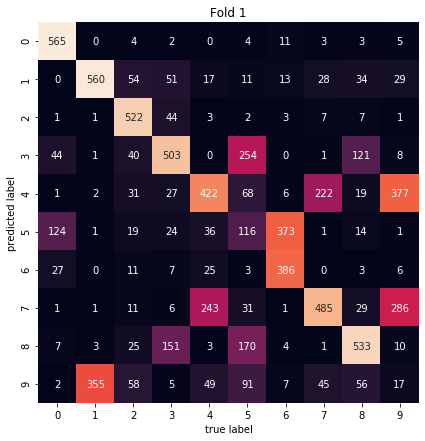

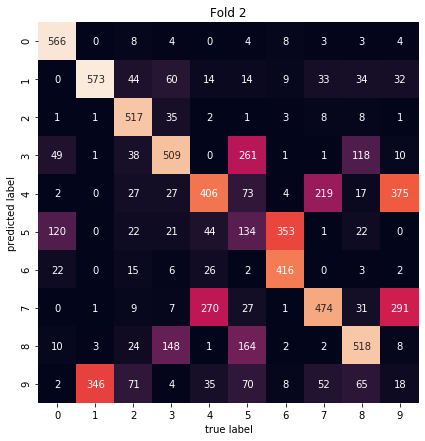

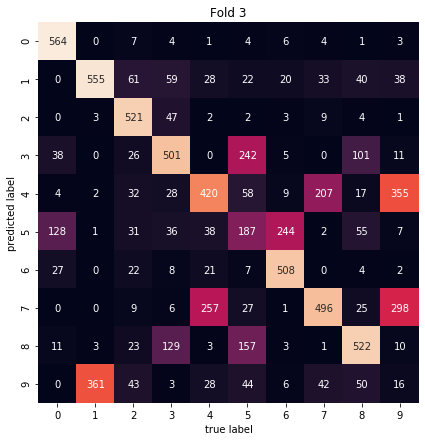

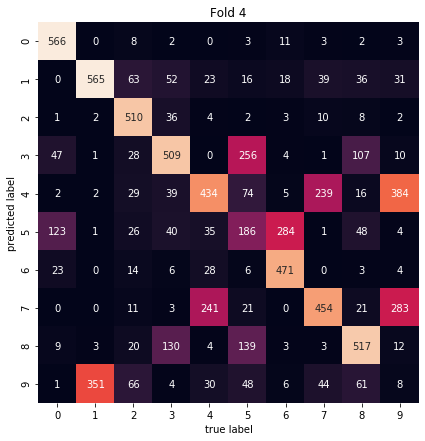

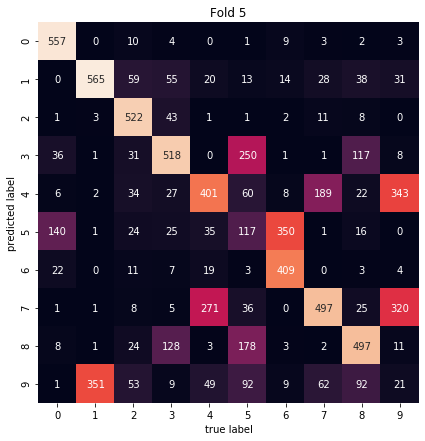

In [150]:
display_conf_matrix(results['mat_train'])

_Testing Accuracy (1NN after KMeans)_

In [151]:
display_accuracy(results['acc_test'], 'Test')

Average Test Accuracy: 0.5252070882359245 with 0.01025514846739745 standart deviation.


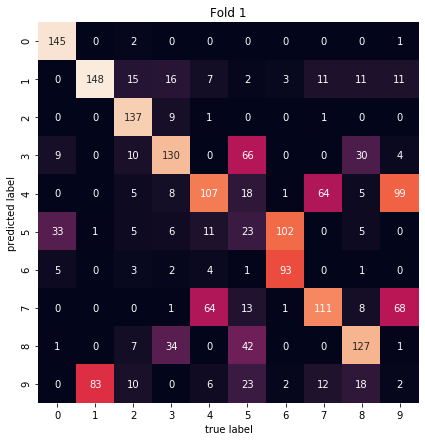

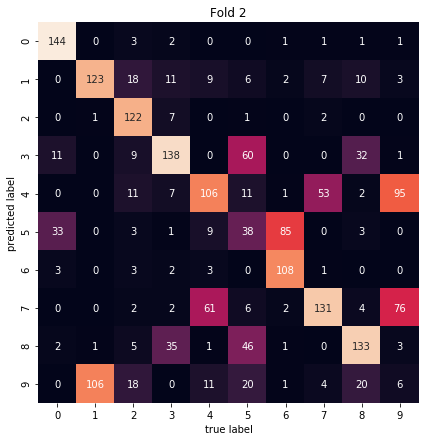

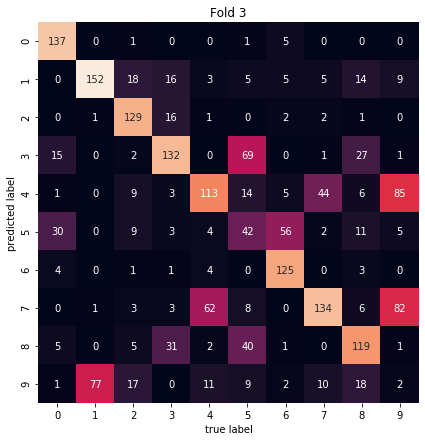

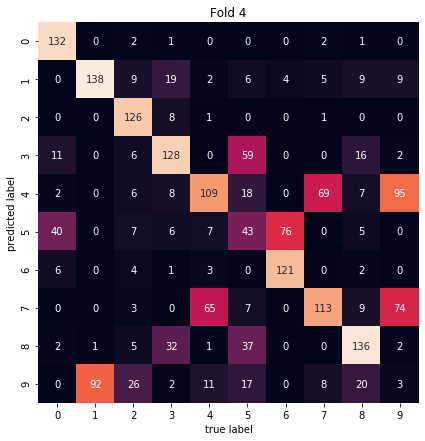

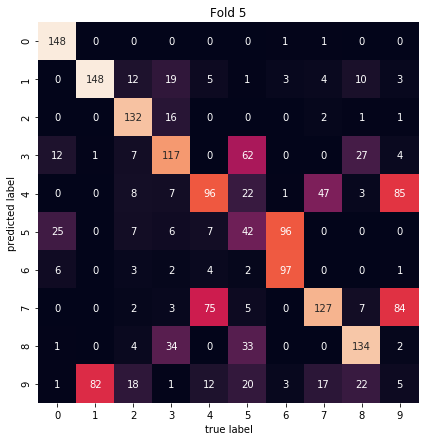

In [152]:
display_conf_matrix(results['mat_test'])

#### <hr style="height:2px;border-width:0;color:gray;background-color:gray">1NN on Test Data<hr style="height:2px;border-width:0;color:gray;background-color:gray">

In [153]:
results = model_evaluation(pc[samples], y[samples], model_1nn)

Running Time: 7.8125


_Testing Accuracy_

In [154]:
display_accuracy(results['acc_test'], 'Test')

Average Test Accuracy: 0.9590042474540953 with 0.004086413694074248 standart deviation.


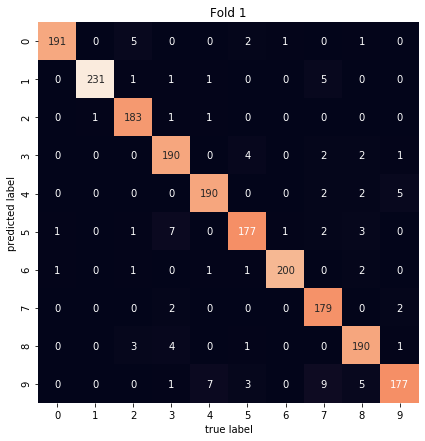

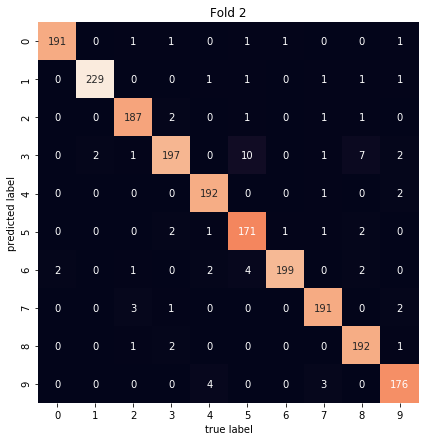

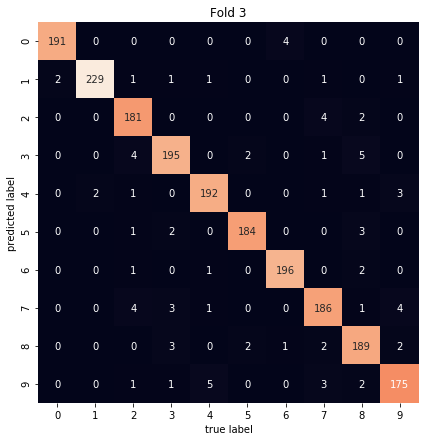

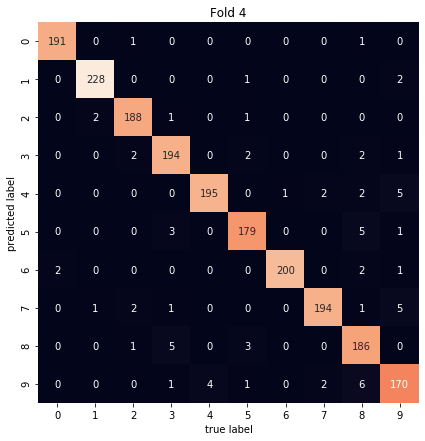

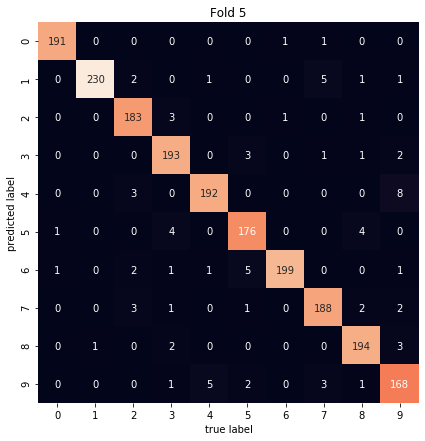

In [155]:
display_conf_matrix(results['mat_test'])

#### <hr style="height:2px;border-width:0;color:gray;background-color:gray">Nearest Centroid on Test and Training Data<hr style="height:2px;border-width:0;color:gray;background-color:gray">

In [156]:
results = model_evaluation(pc[samples], y[samples], model_nearest_centroid)

Running Time: 0.328125


_Training and Testing Accuracy_

In [157]:
display_accuracy(results['acc_train'], 'Train')
display_accuracy(results['acc_test'], 'Test')

Average Train Accuracy: 0.8006252057673017 with 0.0016617688849380186 standart deviation.
Average Test Accuracy: 0.7987983040668739 with 0.009927051675870916 standart deviation.


#### <hr style="height:2px;border-width:0;color:gray;background-color:gray">1NN after KMeans model on scikit-learn digit data
<hr style="height:2px;border-width:0;color:gray;background-color:gray">

In [158]:
digits = load_digits()
data = digits.data
target = digits.target
labels = np.unique(target)
num_component=40
pc_data = dimension_reduction(data, num_component)
results = model_evaluation(pc_data, target, model_kmeans_1nn)
display_accuracy(results['acc_train'], 'Train')
display_accuracy(results['acc_test'], 'Test')

Running Time: 3.4375
Average Train Accuracy: 0.7862895105288961 with 0.019265648016875258 standart deviation.
Average Test Accuracy: 0.779861139197669 with 0.0387675985043586 standart deviation.


## Part II: Conclusions

* When we used kmeans on keras digit dataset accuracy got quite low. We tried to predict the test data with 1nn after kmeans clustering but there was no significant difference. We used individual labeled train samples in clusters for 1nn. After the examination of confusion matrices we saw that the model predicted 0, 1, 2 and 6 digits very well. It didn't recognize almost any 5 digit data.

* Since, this didn't work very well, we tried nearest centroid method and only 1nn as well. These two models gave much better accuracy. 

* Finally, we examined model_kmeans_1nn with scikit-learn digit data as well. We saw that the model performed much better on this data(Accuracy difference is quite high compared to keras digit dataset).